In [252]:
from graphviz import Digraph, nohtml
from bisect import insort_left, bisect_left
from math import floor
from random import randint

# Arbres-B

Pour un arbre d'ordre m:
- Noeuds : m <= k <= 2m clés
- Racine : 1 <= k <= 2m clés

# Table des matières <a class="anchor" id="menu"></a>
* [Graphviz](#graphviz)
* [Arbre-B et PageB](#btree)
* [Tests](#tests)
<!-- * [Arbre-B et PageB V2](#btree2) -->

## Graphviz <a class="anchor" id="graphviz"></a>                                                                                                                                  
#### [Retour](#menu) 

In [253]:
def visualiser_arbre(arbreB):
    # dot = Digraph()
    dot = Digraph(node_attr={'shape': 'record', 'height': '0.1', 'width': '0.02'})
    index = 0

    def bufferNoeud(cles):
        buffer = "<f0> |"
        for i in range(len(cles)):
            buffer += "<f" + str(2*i+1) + "> " + str(cles[i]) + "|" # case cle : indice impair
            if i != len(cles)-1:
                buffer += "<f" + str(2*i+2) + "> " + "|" # case pointeur vers enfant : indice pair
            else:
                buffer += "<f" + str(2*i+2) + "> "
        return buffer
    
    def traverse(pageB):
        nonlocal index

        if pageB is None:
            return

        buffer = bufferNoeud(pageB.cles)
        dot.node(str(index), nohtml(buffer))
        # index += 1
        
        idParent = index
        for i in range(len(pageB.enfants)):
            parent = str(idParent) + ":f" + str(2*i)
            index += 1
            enfant = str(index)
            dot.edge(parent, enfant)
            traverse(pageB.enfants[i])
    
    traverse(arbreB.racine)
    return dot

## Arbre-B et PageB <a class="anchor" id="btree"></a>                                                                                                                                  
#### [Retour](#menu) 

In [254]:
class PageB:
    def __init__(self, cles:'list'=[]):
        self.cles = cles # nbCles noeud : entre m et 2m, nbCles racine : entre 1 et 2m
        self.enfants = []
        self.parent = None

    def _est_page_vide(self):
        """ Retourne true si la page self est vide (sans cle).
        """
        return self.cles == []

    def _est_page_externe(self):
        """ Retourne true si self est une page externe (feuille).
        """
        return len(self.enfants) == 0

    def _est_debordement_page(self, nbMaxCles):
        """ Retourne true si la page self depasse sa limite de cles (2*ordre).    
        """
        return len(self.cles) > nbMaxCles
    
    def _est_suppression_sans_deficit(self, nbMinCles):
        """ Retourne true si la suppression d'une cle de la page self n'entraine pas
            de deficit en cle ie. si len(self.cles) > nbMinCles (racine : minimum 1 cle
            et noeud : minimum m cles, avec m = ordre de l'arbreB).
        """
        if self.parent is None: # racine : nbCles min = 1
            return len(self.cles) > 1
        else: # noeud : nbCles min = m
            return len(self.cles) > nbMinCles
    
    def _est_page_en_deficit(self, nbMinCles):
        """ Retourne true si la page self est en deficit de cle ie. si len(self.cles) < nbMinCles.
        """
        if self.parent is None: # racine : nbCles min = 1
            return len(self.cles) < 1
        else: # noeud : nbCles min = m
            return len(self.cles) < nbMinCles

    def _recherche_page(self, cle):
        """ Retourne true si cle est dans la page self.
        """
        return cle in self.cles
    
    def _duplique_page(self, parent:'PageB'=None):
        """ Retourne le duplique de la page self.
        """
        duplique = PageB(self.cles.copy())
        duplique.parent = parent
        for enfant in self.enfants:
            duplique.enfants.append(enfant._duplique_page(parent=duplique))
        return duplique


    def _indice_page_suivante(self, cle):
        """ Retourne l'indice de la page suivante (enfant de la page self) qui pourrait
            contenir la cle cle.
            Hypothese : self n'est pas une page externe (sinon pas de page suivante)
        """
        assert not self._est_page_externe(), "indicePageSuivante : self est une page externe, pas de page suivante!"
        indice = bisect_left(self.cles, cle)
        return indice
    
    def _frere_gauche(self, indicePage) -> 'PageB':
        """ indicePage : indice de la page self parmi les enfants de son parent.\n
            Retourne le frere gauche de la page self s'il existe,
            None si self ne possede pas frere gauche (self est
            la racine ou l'enfant le plus a gauche de son parent).
        """
        if self.parent is None or indicePage == 0: # self est la racine ou n'a pas de frere gauche
            return None
        else:
            return self.parent.enfants[indicePage - 1]
            
    def _frere_droit(self, indicePage) -> 'PageB':
        """ indicePage : indice de la page self parmi les enfants de son parent.\n
            Retourne le frere droit de la page self s'il exitse,
            None si self ne possede pas de frere droit (self est
            la racine ou l'enfant le plus a droite de son parent).
        """
        if self.parent is None or indicePage == len(self.parent.enfants) - 1: # self est la racine ou n'a pas de frere droit
            return None
        else:
            return self.parent.enfants[indicePage + 1]

    def _emprunter_cle_frere(self, frere:'PageB', indiceCle, estGauche:bool):
        """ Emprunte une cle de son frere gauche ou droit. Echange la
            cle empruntee avec une cle du parent pour respecter l'ordre des cles.
            La cle du parent a echanger est celle qui est a position indiceCle parmi
            les cles du parent.
            Si self n'est pas une feuille, elle recupere un enfant du frere (sinon
            deficit enfants).
            Hypothese : l'emprunt d'une cle de son frere n'entraine pas
            de deficit.
        """
        cleParent = self.parent.cles.pop(indiceCle) # cle du parent a echanger pour respecter l'ordre
        if estGauche: # emprunt au frere gauche
            cleEmpruntee = frere.cles.pop(len(frere.cles)-1) # emprunter la derniere cle du frere gauche
            self.cles.insert(0, cleParent) # la cle du parent devient la plus petite cle de self
            if not self._est_page_externe(): # si self n'est pas une feuille, recuperer un enfant du frere
                enfantFrere = frere.enfants.pop(len(frere.enfants)-1) # frere gauche cede son dernier enfant a self
                enfantFrere.parent = self
                self.enfants.insert(0, enfantFrere) # l'enfant du frere gauche devient le 1er enfant de self
        
        else: # emprunt au frere droit
            cleEmpruntee = frere.cles.pop(0) # emprunter la 1ere cle du frere droit
            self.cles.append(cleParent) # la cle du parent devient la plus grande cle de self
            if not self._est_page_externe():
                enfantFrere = frere.enfants.pop(0) # frere droit cede son 1er enfant a self
                enfantFrere.parent = self
                self.enfants.append(enfantFrere) # l'enfant du frere droit devient le dernier enfant de self
        self.parent.cles.insert(indiceCle, cleEmpruntee) # ajouter au parent la cle empruntee


    def _cle_predecesseur_dans_enfant(self):
        """ Fonction auxiliaire récursive de _suppression, retourne la cle predecesseur
            de cle dans l'enfant de page.
        """
        if self._est_page_externe(): # feuille : recuperer la cle max
            return self.cles[len(self.cles)-1]
        else: # noeud interne : continuer a chercher dans le sous-arbre droit
            return self.enfants[len(self.enfants)-1]._cle_predecesseur_dans_enfant()


    def _compensation_deficit(self, nbMinCles, indicePage):
        """ Compense le deficit de cles de la page self en empruntant une cle
            a son frere gauche ou droite si cette operation est possible, sinon
            fusionne la page self avec son frere gauche ou droite.
            Hypothese : self est en deficit de cles.
        """
        nouvelIndice = indicePage
        frereGauche = self._frere_gauche(nouvelIndice)
        frereDroit = self._frere_droit(nouvelIndice)
        if frereGauche is not None and frereGauche._est_suppression_sans_deficit(nbMinCles):
            self._emprunter_cle_frere(frereGauche, nouvelIndice-1, estGauche=True) # gauche -> indice cle enfant gauche
        elif frereDroit is not None and frereDroit._est_suppression_sans_deficit(nbMinCles):
            self._emprunter_cle_frere(frereDroit, nouvelIndice, estGauche=False) # droite -> indice cle enfant self
        else: # cas fusion
            if frereGauche is not None:
                self = self._fusion_page(frereGauche, nouvelIndice-1, estGauche=True)
                nouvelIndice = nouvelIndice - 1 # nouvelIndice = celui du frere gauche
            elif frereDroit is not None:
                self = self._fusion_page(frereDroit, nouvelIndice, estGauche=False)
        return self, nouvelIndice


    def _ajout_page_externe(self, cle):
        """ Ajoute la cle cle dans la page externe self.
        """
        assert self._est_page_externe(), "ajoutPageExterne : pas une page externe!"
        insort_left(self.cles, cle)

    def _eclatement(self, indicePage):
        """ indicePage : indice de la page self parmi les enfants de son parent, -1 si pas de parent.\n
            Eclate la page courante self en deux pages. La cle mediane est
            recuperee par le parent de self et les enfants de self sont
            partages entre les deux nouvelles pages.
            Si self n'a pas de parent (cas de la racine), une nouvelle
            racine est creee.
            Retourne soit le parent de self, soit la nouvelle racine.
            Hypothese : eclatement si len(self.cles) = 2*ordre+1 (debordement)
        """
        # Etapes :
        # - eclater self en 2 nouvelles pages : pageMoitieGauche et pageMoitieDroite,
        #   qui deviennent enfants du parent de self a la place de self (supprimer self
        #   des enfants de son parent)
        # - le parent recupere la cle mediane des cles de self
        # - les enfants de self enfantsGauche et enfantsDroite deviennent
        #   respectivement les enfants de pageMoitieGauche et pageMoitieDroite
        #   (remarque : si self a k cles alors self a k+1 enfants -> nombre d'enfants
        #   donc egal a 2*(ordre+1) -> pair)
        # - cas 1 : self a un parent -> suivre les etapes du dessus
        # - cas 2 : self n'a pas de parent car c'est la racine
        #   -> creer une nouvelle racine qui a pour unique
        #      cle la cle mediane et comme enfants les 2 nouvelles pages

        moitie = floor(len(self.cles)/2)
        cleMediane = self.cles[moitie]
        pageMoitieGauche = PageB(self.cles[:moitie]) # indice moitie pas inclus
        pageMoitieDroite = PageB(self.cles[moitie+1:]) # indice moitie+1 inclus

        if not self._est_page_externe(): # nb enfants = nb cles+1
            pageMoitieGauche.enfants = self.enfants[:moitie+1] # les nouvelles pages recuperent
            pageMoitieDroite.enfants = self.enfants[moitie+1:] # les enfants de self
            for page in self.enfants[:moitie+1]:
                page.parent = pageMoitieGauche
            for page in self.enfants[moitie+1:]:
                page.parent = pageMoitieDroite

        if self.parent is None: # self est racine -> creer une nouvelle racine
            nvRacine = PageB([cleMediane])
            nvRacine.enfants = [pageMoitieGauche, pageMoitieDroite]
            pageMoitieGauche.parent = nvRacine
            pageMoitieDroite.parent = nvRacine
            self.parent = nvRacine
            return nvRacine
        else: # un parent
            insort_left(self.parent.cles, cleMediane) # le parent recupere cle mediane
            self.parent.enfants.pop(indicePage)
            self.parent.enfants.insert(indicePage, pageMoitieGauche)
            self.parent.enfants.insert(indicePage+1, pageMoitieDroite)
            pageMoitieGauche.parent = self.parent
            pageMoitieDroite.parent = self.parent
            return self.parent


    def _fusion_page(self, frere:'PageB', indiceCle, estGauche:bool):
        """ Fusionne la page self avec une page frere gauche en ajoutant les cles de
            self dans celles de frere. Descend une cle du parent pour respecter
            l'ordre des cles dans l'ArbreB. Recupere les enfants de self et du frere.
            Retourne la page resultante.
        """
        fusion = PageB() # page contenant la fusion des cles de frere et self
        fusion.parent = self.parent
        if estGauche:
            cleParent = fusion.parent.cles.pop(indiceCle) # cle a descendre (et a supprimer du parent)
            fusion.cles = frere.cles + [cleParent] + self.cles
            fusion.enfants = frere.enfants + self.enfants # recuperer les enfants
        else: # frere droite
            cleParent = fusion.parent.cles.pop(indiceCle) # cle a descendre (et a supprimer du parent)
            fusion.cles = self.cles + [cleParent] + frere.cles
            fusion.enfants = self.enfants + frere.enfants # recuperer les enfants
        for enfant in fusion.enfants: # mettre a jour le nouveau parent des enfants
            enfant.parent = fusion
        fusion.parent.enfants.pop(indiceCle) # retirer self des enfants du parent
        fusion.parent.enfants.pop(indiceCle) # retirer frere des enfants du parent
        fusion.parent.enfants.insert(indiceCle, fusion) # ajouter la page resultante dans les enfants du parent
        return fusion
    

        

class ArbreB:
    def __init__(self, ordre):
        assert ordre > 0, "ArbreB : veuillez choisir un ordre strictement positif!"
        self.racine = None
        self.ordre = ordre # ordre = nombre de cles min dans un noeud non racine
        self.NBCLESMAX = 2*ordre
    
    def est_vide(self):
        return self.racine is None
    
    def _duplique(self):
        """ Retourne le duplique de l'ArbreB self.
        """
        if self.est_vide():
            return self
        duplique = ArbreB(self.ordre)
        duplique.racine = self.racine._duplique_page()
        return duplique
 
    def recherche(self, cle):
        """ Retourne true si cle est dans l'arbre-B self en
            cherchant dans les pagesB de l'arbre-B a l'aide
            de la fonction _recherche(pageB, cle).
        """
        if self.est_vide():
            return False
        return self._recherche(self.racine, cle)
    
    def _recherche(self, page:PageB, cle):
        """ Retourne true si la cle est dans l'arbre-B self en
            cherchant si la cle est dans une pageB de l'arbre.
        """
        if page._recherche_page(cle): # cle est dans la page courante
            return True
        else: # sinon continuer a chercher
            if page._est_page_externe(): # pas d'enfant : fin recherche
                return False
            else: # chercher dans la page suivante qui pourrait contenir la cle
                pageSuivante = page.enfants[page._indice_page_suivante(cle)]
                return self._recherche(pageSuivante, cle)


    def ajout(self, cle):
        if self.est_vide():
            self.racine = PageB([cle])
        else:
            self.racine, _ = self._ajout(self.racine, cle)


    def _ajout(self, page:PageB, cle, parent:PageB=None, indicePage=-1) -> tuple[PageB, bool]:
        """ indicePage : indice de la page parmi les enfants de son parent, -1 si pas de parent.\n
            Retourne la page resultante de l'ajout de la cle dans la page et un booleen indiquant
            si un eclatement a eu lieu (dans ce cas, la page retournee est le parent).
        """
        if page._recherche_page(cle): # cle deja dans une page de arbre-B
            return page, False
        
        nouvellePage = PageB(page.cles.copy()) # copier la page courante
        nouvellePage.parent = parent
        if page._est_page_externe(): # page externe (feuille) : ajout ok            
            nouvellePage._ajout_page_externe(cle)

        else: # ajout dans page suivante (enfant)
            indice = page._indice_page_suivante(cle) # indice de la page suivante (enfant) ou ajouter la cle
            for i in range(len(page.enfants)): # copier tous les enfants sauf celui ou on va ajouter la cle
                if i == indice: # ajouter temporairement l'ancien enfant (necessaire si eclatement)
                    nouvellePage.enfants.append(page.enfants[i])
                else:
                    nouvelEnfant = page.enfants[i]._duplique_page(parent=nouvellePage)
                    nouvellePage.enfants.append(nouvelEnfant)
            pageSuivante = nouvellePage.enfants[indice] # page enfant ou ajouter la cle
            pageSuivante, eclatement = self._ajout(pageSuivante, cle, nouvellePage, indice)
            if eclatement:
                nouvellePage = pageSuivante
            else:
                nouvellePage.enfants[indice] = pageSuivante # inserer l'enfant ou on a ajoute la cle

        # eclatement (retourne le parent de la page eclatee ou la nouvelle racine si on eclate la racine)
        if nouvellePage._est_debordement_page(self.NBCLESMAX):
            nouveauParent = nouvellePage._eclatement(indicePage)
            if nouveauParent.parent is None: # cas augmentation hauteur
                self.racine = nouveauParent # mise a jour de la racine
            return nouveauParent, True
        else:
            return nouvellePage, False

                    

    def suppression(self, cle):
        if self.est_vide():
            return
        else:
            self.racine, _ = self._suppression(self.racine, cle)


    def _suppression(self, page:PageB, cle, parent:PageB=None, indicePage=-1) -> tuple[PageB, int]:
        """ indicePage : indice de la page parmi les enfants de son parent, -1 si pas de parent.\n
            Retourne la page resultante de la suppression de la cle dans la page et l'indice
            de la page parmi les enfants de son parent.
            Si la cle a supprimer se trouve au niveau d'un noeud interne, elle est remplacee par sa
            cle predecesseur dans l'enfant du noeud interne et la fonction fait un appel recursif
            pour supprimer la cle predecesseur.
            Si suite a une suppression, la page est en deficit de cles, la fonction fait appel a
            _compensation_deficit pour emprunter une cle a un frere ou fusionner avec un frere.
        """
        if page._recherche_page(cle): # on a trouve la cle a supprimer
            if parent is None and len(page.cles) == 1 and page.enfants == []: # arbreB = 1 cle a la racine
                return None, -1
            
            nouvellePage = PageB(page.cles.copy()) # copier la page courante
            nouvellePage.parent = parent
            if page._est_page_externe(): # suppression au niveau d'une feuille : ok
                nouvellePage.cles.remove(cle)

            else: # sinon, suppression au niveau d'un noeud interne
                indice = nouvellePage.cles.index(cle)
                pagePrecedente = page.enfants[indice] # page contenant la cle predecesseur de cle
                for i in range(len(page.enfants)):
                    if i == indice:
                        nouvellePage.enfants.append(pagePrecedente)
                    else:
                        nouvelEnfant = page.enfants[i]._duplique_page(parent=nouvellePage)
                        nouvellePage.enfants.append(nouvelEnfant)

                cleRemplacement = pagePrecedente._cle_predecesseur_dans_enfant()
                nouvellePage.cles[indice] = cleRemplacement # echanger cle a supprimer par cle predecesseur
                # supprimer la cle predecesseur dans l'enfant pagePrecedente
                pagePrecedente, nouvelIndice = self._suppression(pagePrecedente, cleRemplacement, nouvellePage, indice)
                nouvellePage = pagePrecedente.parent # mise a jour de nouvellePage
                nouvellePage.enfants[nouvelIndice] = pagePrecedente # ok, on retourne None que pour le cas racine avec 1 cle
        
        else: # sinon, continuer a chercher la cle a supprimer
            if page._est_page_externe(): # cle a supprimer non trouvee dans l'arbre-B
                return page, indicePage # indicePage ne change pas
            else:
                nouvellePage = PageB(page.cles.copy()) # copier la page courante
                nouvellePage.parent = parent
                indice = page._indice_page_suivante(cle)
                pageSuivante = page.enfants[indice] # page suivante ou chercher la cle a supprimer
                for i in range(len(page.enfants)):
                    if i == indice:
                        nouvellePage.enfants.append(pageSuivante)
                    else:
                        nouvelEnfant = page.enfants[i]._duplique_page(parent=nouvellePage)
                        nouvellePage.enfants.append(nouvelEnfant)

                pageSuivante, nouvelIndice = self._suppression(pageSuivante, cle, nouvellePage, indice)
                nouvellePage = pageSuivante.parent # mise a jour de nouvellePage 
                nouvellePage.enfants[nouvelIndice] = pageSuivante

        # verifier si apres suppression, la page est en deficit de cles
        nouvelIndicePage = indicePage
        if nouvellePage.parent is None and nouvellePage._est_page_vide() and len(nouvellePage.enfants) == 1:
            # si nouvellePage = racine mais pas de cle apres avoir cede une cle a un de ses enfants
            # (apres une fusion), cas diminution hauteur -> nouvelle racine = enfant unique de nouvellePage
            self.racine = nouvellePage.enfants[0] # mise a jour de la racine
            return nouvellePage.enfants[0], -1
                  
        if nouvellePage._est_page_en_deficit(self.ordre): # deficit : emprunt ou fusion
            nouvellePage, nouvelIndicePage = nouvellePage._compensation_deficit(self.ordre, nouvelIndicePage)
        return nouvellePage, nouvelIndicePage
    


    # def suppression_version_preemptive(self, cle):
    #     """ Suppression de la cle cle dans l'arbre-B self en utilisant
    #         une verification preemptive des proprietes de l'arbre-B avant 
    #         de descendre dans un noeud. Cf. Cormen Introduction a l'algorithmique.
    #         Hypothese : l'ordre de l'arbre-B est pair.
    #         Remarque : la suppression preemptive evite la remontee supplementaire dans
    #         l'arbre pour verifier les proprietes de l'arbre-B.
    #     """
    #     assert self.ordre % 2 == 0, "suppression_version_preemptive : ordre doit etre pair!"
    #     if self.est_vide():
    #         return
    #     else:
    #         self.racine = self._suppression_version_preemptive(self.racine, cle)

## Tests <a class="anchor" id="tests"></a>                                                                                                                                  
#### [Retour](#menu) 

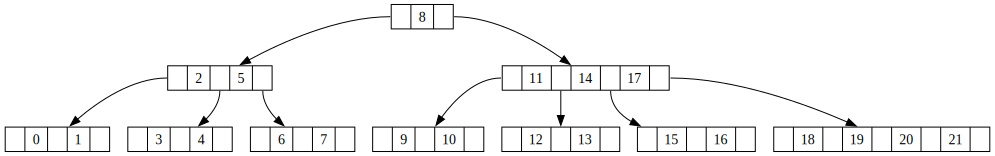

In [255]:
btree = ArbreB(2)
for i in range(22):
    # i = randint(0,80)
    # print("ajout de cle ",i)
    btree.ajout(i)

# if btree.recherche(16):
#     print("j'ai trouve !")
# else:
#     print("recherche echouee ?")

dot = visualiser_arbre(btree)
dot
# print(dot.source) 

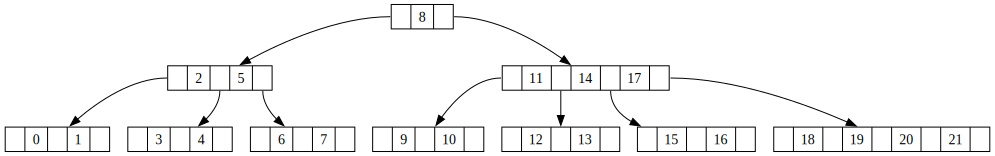

In [256]:
duplique = btree._duplique()
dot2 = visualiser_arbre(duplique)
dot2

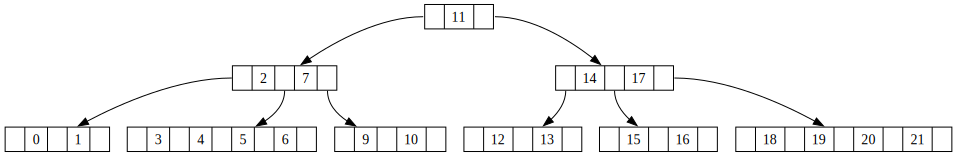

In [257]:
duplique.suppression(8)
dot0 = visualiser_arbre(duplique)
dot0

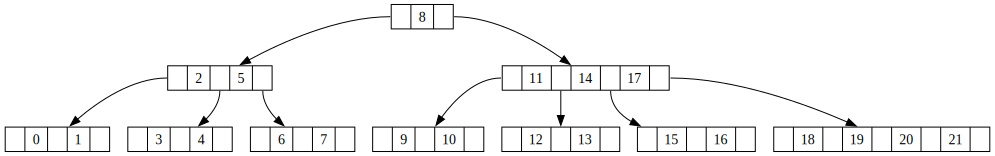

In [258]:
dot = visualiser_arbre(btree)
dot

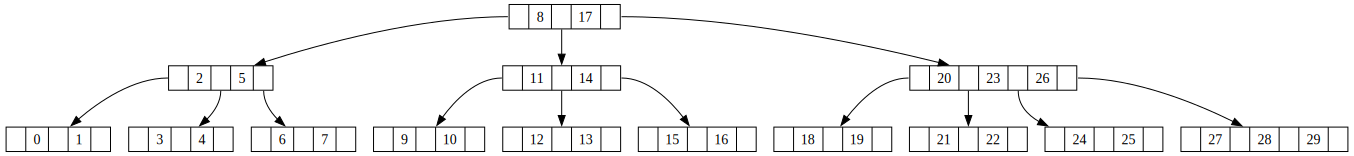

In [259]:
btree3 = ArbreB(2)
for i in range(30):
    # k = randint(1,20)
    # print("ajout de cle ",k)
    btree3.ajout(i)
dot3 = visualiser_arbre(btree3)
dot3

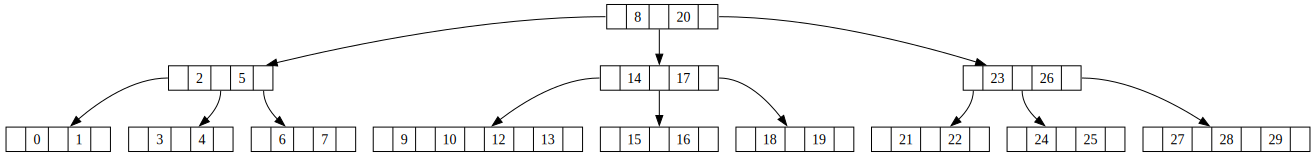

In [260]:
btree3.suppression(11)
dot4 = visualiser_arbre(btree3)
dot4

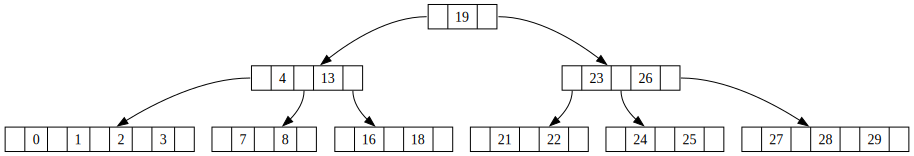

In [261]:
btree3.suppression(15)
btree3.suppression(14)
btree3.suppression(17)
btree3.suppression(20)
btree3.suppression(12)
btree3.suppression(10)
btree3.suppression(9)
btree3.suppression(5)
btree3.suppression(6)
dot5 = visualiser_arbre(btree3)
dot5

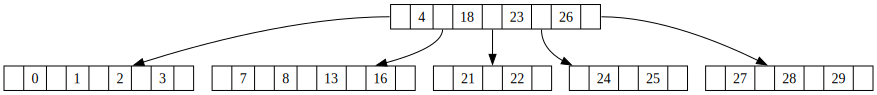

In [262]:
# btree3.ajout(8)
btree3.suppression(19)
dot6 = visualiser_arbre(btree3)
dot6

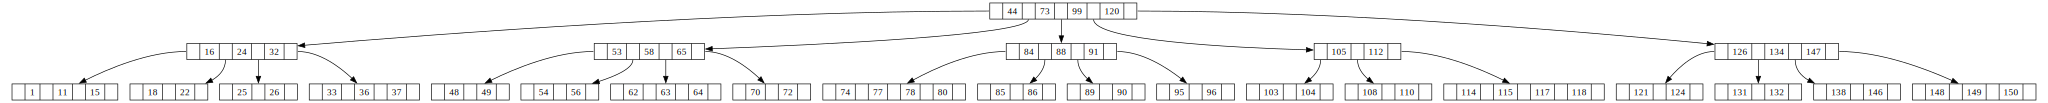

In [263]:
btree4 = ArbreB(2)
for i in range(100):
    i = randint(1,150)
    btree4.ajout(i)
dot7 = visualiser_arbre(btree4)
dot7

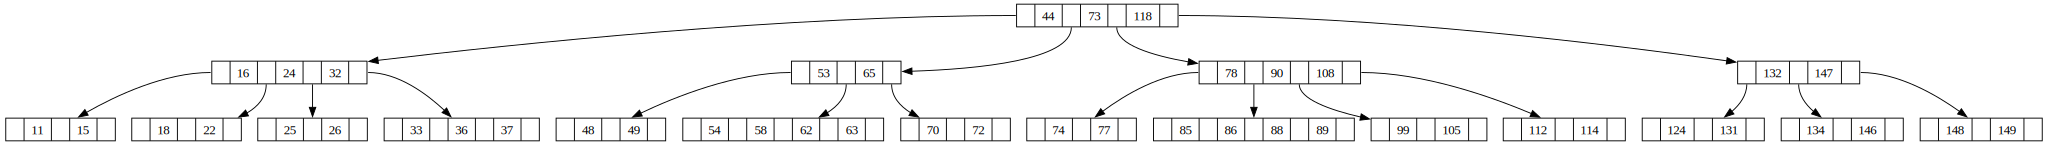

In [264]:
for i in range(50):
    i = randint(1,150)
    btree4.suppression(i)
dot8 = visualiser_arbre(btree4)
dot8